<a href="https://colab.research.google.com/github/Pk22012003/SalesForecaster/blob/main/bigmartRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
big_mart_data = pd.read_csv('/content/Train.csv')

In [ ]:
# Handle missing values
big_mart_data['Item_Weight'] = big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean())
mode_outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode()[0])
missing = big_mart_data['Outlet_Size'].isnull()
big_mart_data.loc[missing, 'Outlet_Size'] = big_mart_data.loc[missing, 'Outlet_Type'].apply(lambda x: mode_outlet_size[x])

In [ ]:
# Normalize Item_Fat_Content
big_mart_data.replace({'Item_Fat_Content': {'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}}, inplace=True)

In [ ]:
# Feature Engineering
big_mart_data['Item_Category'] = big_mart_data['Item_Identifier'].apply(lambda x: x[:2])
big_mart_data['MRP_Cluster'] = pd.cut(big_mart_data['Item_MRP'], bins=[0, 70, 140, 200, 300], labels=[1, 2, 3, 4])
big_mart_data['Outlet_Years'] = 2025 - big_mart_data['Outlet_Establishment_Year']
big_mart_data['Item_Outlet_Sales_Log'] = np.log1p(big_mart_data['Item_Outlet_Sales'])

In [ ]:
# Encode categorical variables
le = LabelEncoder()
cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type',
        'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type', 'Item_Category']
for col in cols:
    big_mart_data[col] = le.fit_transform(big_mart_data[col])
big_mart_data['MRP_Cluster'] = le.fit_transform(big_mart_data['MRP_Cluster'].astype(str))

In [ ]:
# Features and target
X = big_mart_data.drop(columns=['Item_Outlet_Sales', 'Item_Outlet_Sales_Log'])
y = big_mart_data['Item_Outlet_Sales_Log']

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model and hyperparameter tuning
rf = RandomForestRegressor(random_state=42)

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20,
                                   scoring='r2', n_jobs=-1, cv=3, verbose=1, random_state=42)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='r2', verbose=1)

In [ ]:
best_rf = random_search.best_estimator_

In [ ]:
# Prediction and evaluation
y_pred_log = best_rf.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100


In [ ]:
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MSE: 1121007.58
RMSE: 1058.78
MAE: 720.60
R2 Score: 0.5876
MAPE: 48.96%


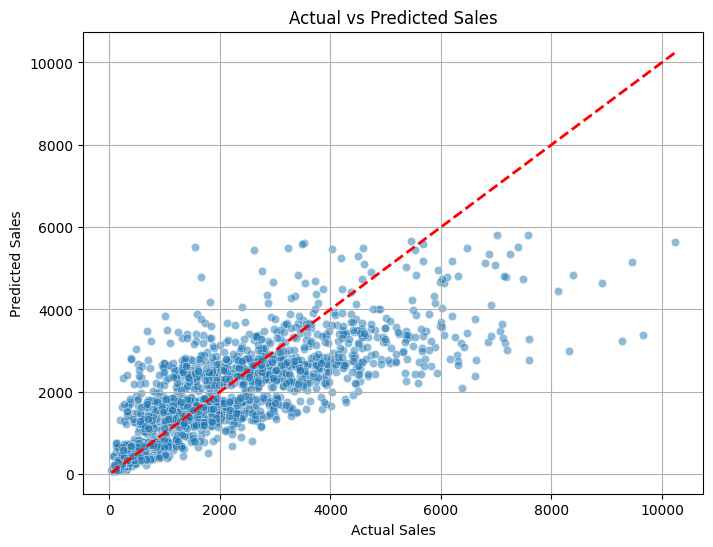

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.grid(True)
plt.show()